# Hands-on tutorial: MCQ Evaluation and Permutation

We'll explore how to:
1. Set up a basic VLM evaluation pipeline
2. Run and interpret Multiple-choice question answering (MCQ) inference
3. Assess the model's robustness to permutation in answer choices.



## VLMs are not robust to permutation in MCQ.

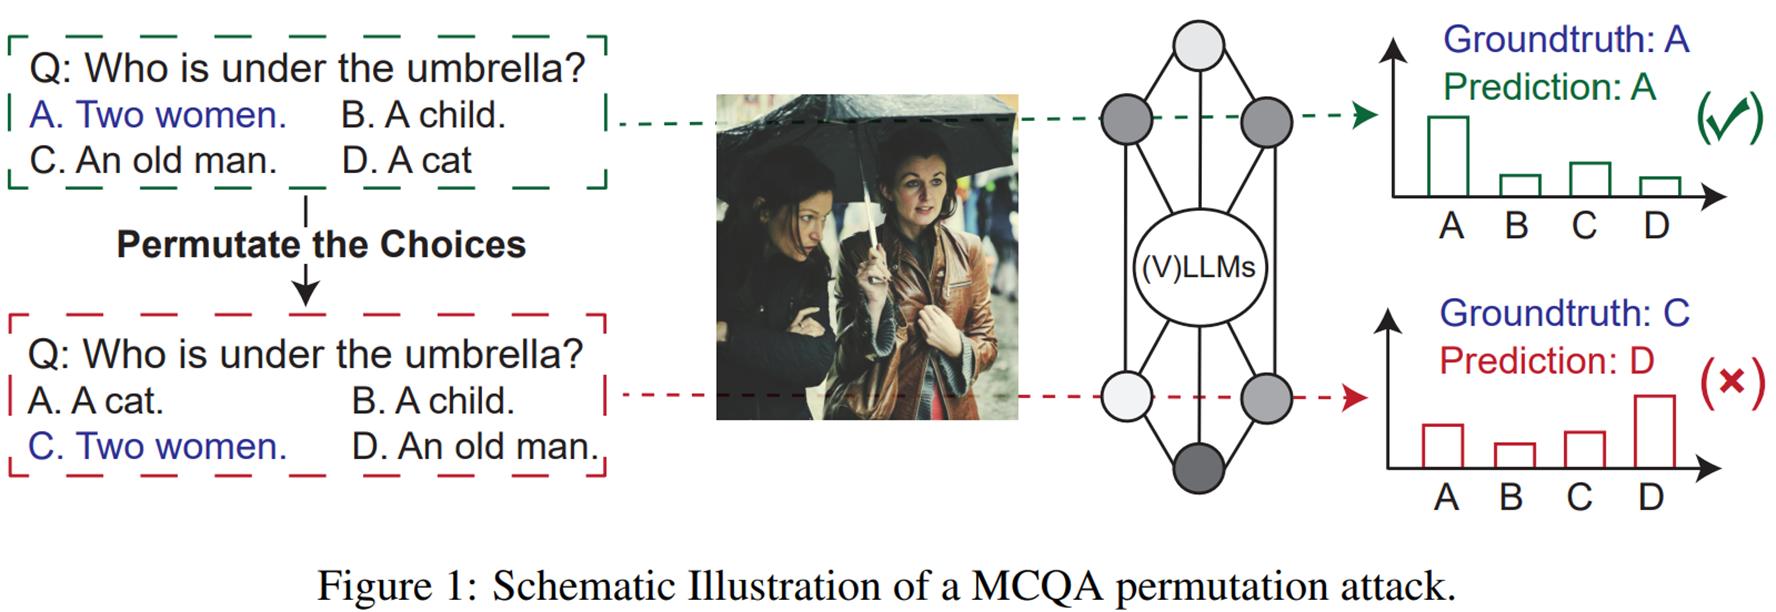

### Load required libraries.
[Pytorch](https://pytorch.org/) and [HuggingFace Transformers](https://huggingface.co/docs/transformers/en/index) are the main libraries we will use. \
[HuggingFace](https://huggingface.co/) is a ML platform where people can host and share their models, datasets, and applications.


In [ ]:
!pip install torch transformers datasets matplotlib

In [ ]:
import requests
from PIL import Image
from datasets import load_dataset
from tqdm import tqdm
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

/home/s2164122/miniconda3/envs/hf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load a Pre-trained VLM
We use one of the most popular VLM [LLaVA-v1.5-7B](https://arxiv.org/abs/2310.03744) as the main model for our experiments.

Q: 7-billion parameters can consumes lots of memory - how to reduce the memory requirement and speed up the inference?

In [ ]:
model_id = "llava-hf/llava-1.5-7b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16, # use float16 for GPU memory efficiency, or bfloat16 for Ampere or Hopper GPUs, e.g. A100/H100 GPU.
    low_cpu_mem_usage=True,
    device_map="cuda:1",
    # attn_implementation="flash_attention_2" # flash attention 2 can be used for faster inference for Ampere/Hopper GPUs
)

processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards: 100%|██████████| 3/3 [00:07<00:00,  2.56s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
#model
for name, module in model.named_children():
    print(name)

vision_tower
multi_modal_projector
language_model


### Load the dataset

**ScienceQA dataset**

[ScienceQA](https://scienceqa.github.io/) is collected from elementary and high school science curricula, and contains 21,208 multimodal multiple-choice science questions. It has richer domain diversity from three subjects: natural science, language science, and social science. ScienceQA features 26 topics, 127 categories, and 379 skills that cover a wide range of domains.
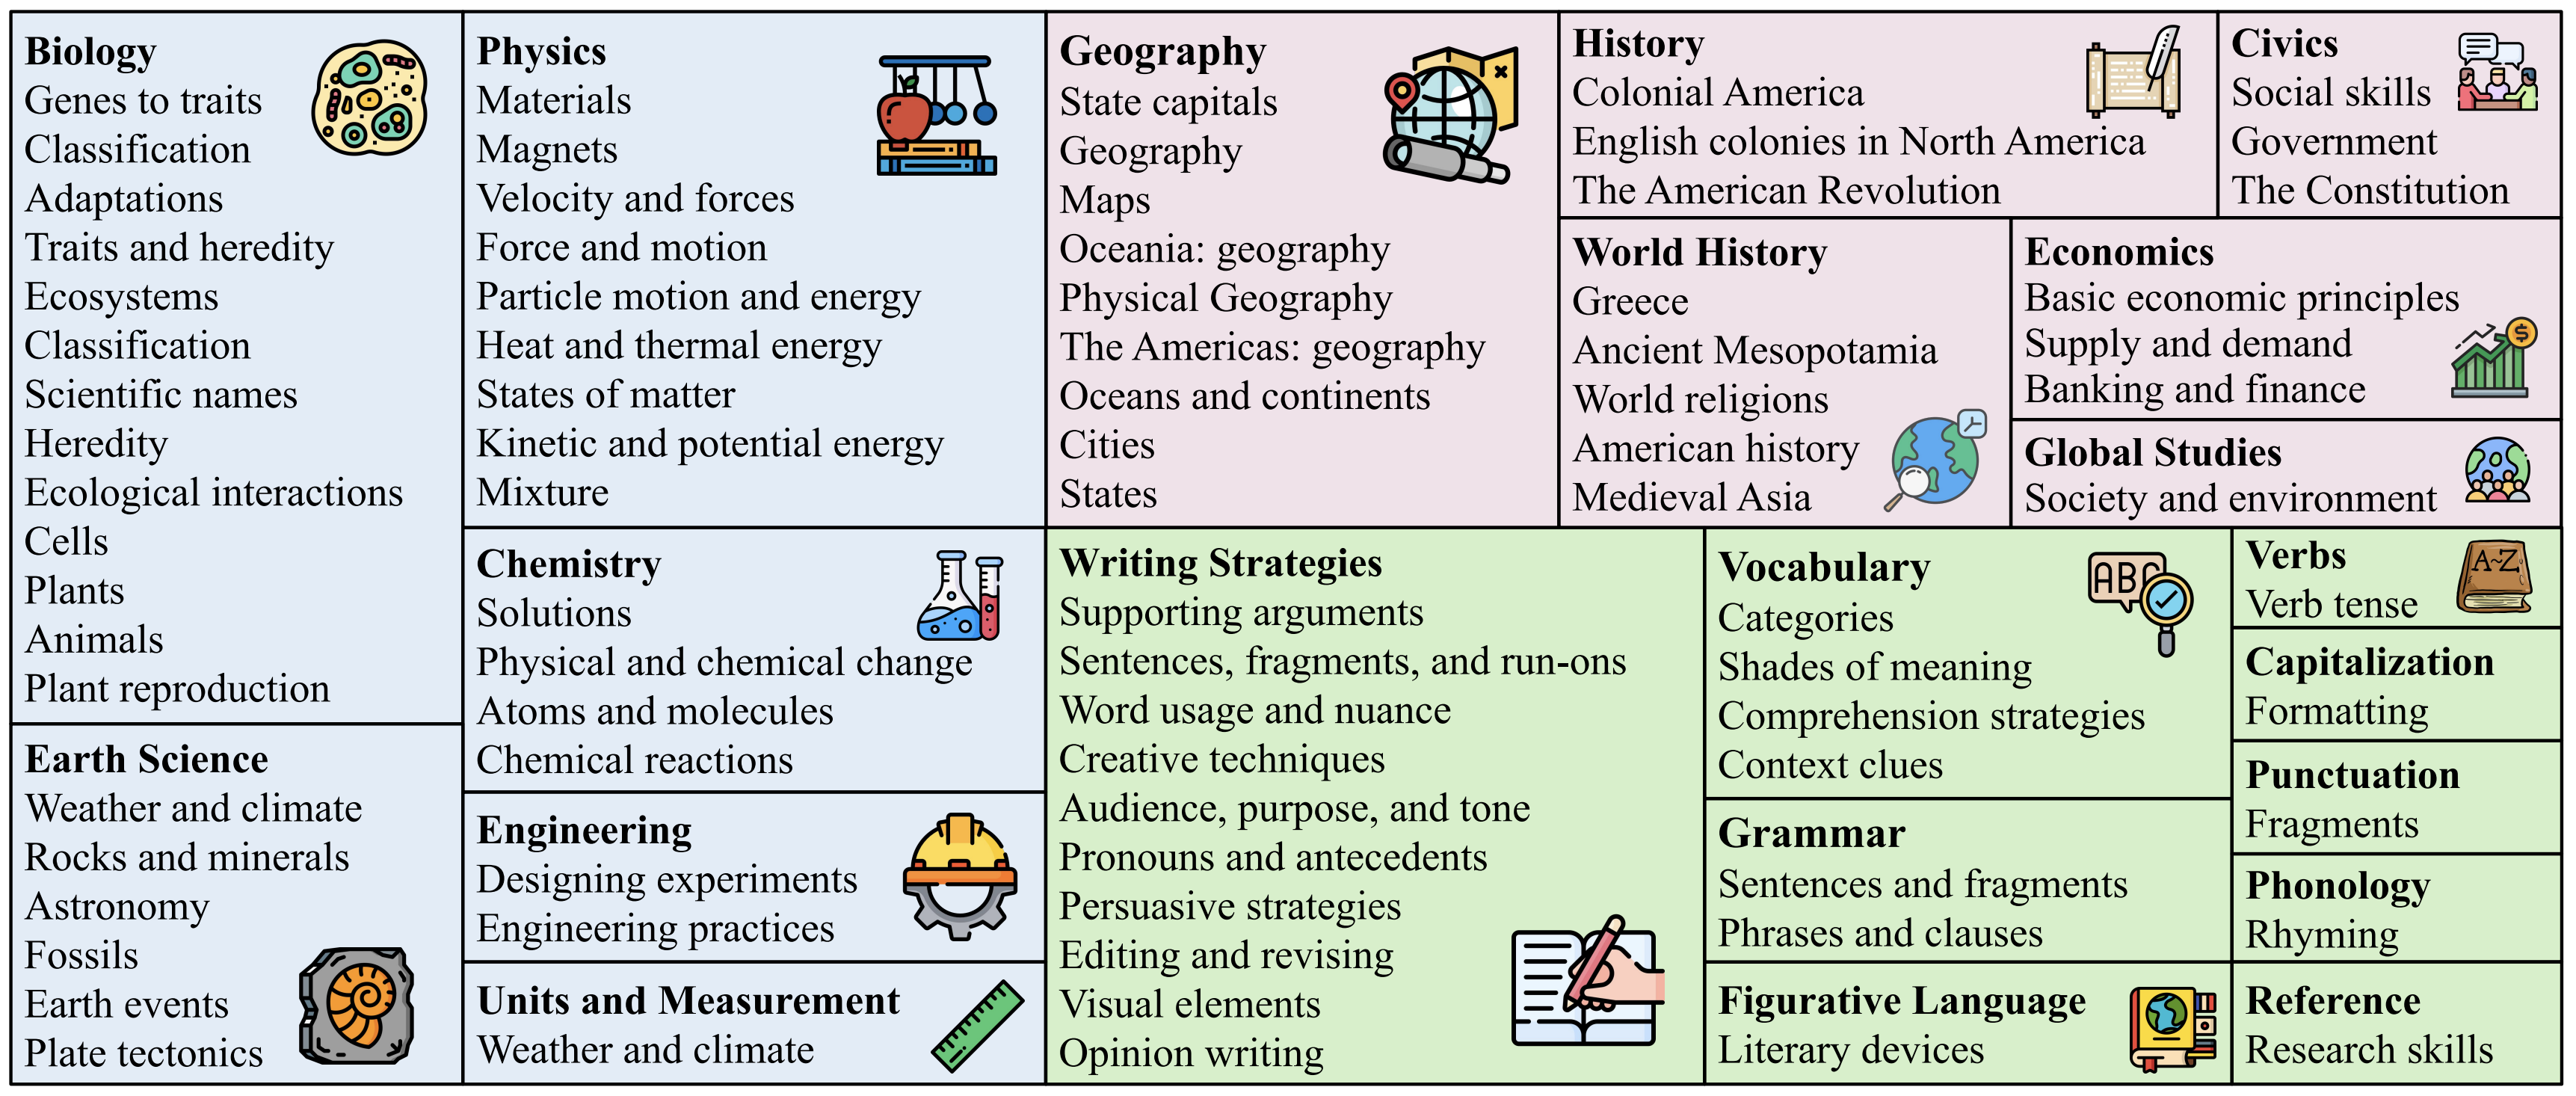

We can also load the dataset from HF if a hosted version is available.

In [ ]:
dataset = load_dataset("lmms-lab/ScienceQA", 'ScienceQA-IMG', split="test")

# Filter: only closed choice tasks with exactly 4 options
def is_valid_closed_choice(example):
    return (
        example["task"] == "closed choice" and
        len(example["choices"]) == 4
    )

filtered_dataset = dataset.filter(is_valid_closed_choice)
print(len(filtered_dataset))  # Check the number of valid examples
# select a subset of 100
filtered_dataset = filtered_dataset.select(range(100))

See how a sample question looks.

In [ ]:
filtered_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=452x595>,
 'question': 'What is the name of the colony shown?',
 'choices': ['Maryland', 'New Hampshire', 'Rhode Island', 'Vermont'],
 'answer': 1,
 'hint': '',
 'task': 'closed choice',
 'grade': 'grade5',
 'subject': 'social science',
 'topic': 'us-history',
 'category': 'English colonies in North America',
 'skill': 'Identify the Thirteen Colonies',
 'lecture': '',
 'solution': 'The colony is New Hampshire.\nDuring the colonial era, New Hampshire and New York both claimed the territory that would later become the state of Vermont. Vermont was never its own colony.'}

Let's visualize the first example

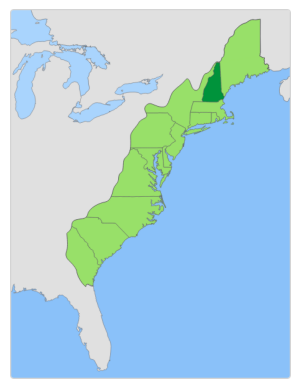

Question: What is the name of the colony shown?
Choices: ['Maryland', 'New Hampshire', 'Rhode Island', 'Vermont']
Answer: 1


In [ ]:

example = filtered_dataset[0]
plt.imshow(example["image"])
plt.axis("off")
plt.show()

print("Question:", example["question"])
print("Choices:", example["choices"])
print("Answer:", example["answer"]) # 0-indexed

## Inference

We'll define a helper function that:
1) Builds a conversation in LLaVA-style,
2) Processes the text+image,
3) Generates a one-letter answer (A/B/C/D).


In [ ]:
def build_conversation(question, choices):
    """
    Build the LLaVA chat format:
    - We instruct the model to answer with a single letter from A/B/C/D.
    - We'll add an image placeholder so LLaVA can handle the image.
    """
    user_text = (
        "Please answer the following multiple-choice question with exactly one letter: A, B, C, or D.\n\n"
        f"Question: {question}\n"
        f"A. {choices[0]}\n"
        f"B. {choices[1]}\n"
        f"C. {choices[2]}\n"
        f"D. {choices[3]}\n"
        "Answer:"
    )
    # LLaVA expects a list with a dict that has "role" and "content",
    # where content is a list of {"type": "text"} or {"type": "image"}.
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": user_text},
                {"type": "image"},  # We'll attach the actual image later
            ],
        },
    ]
    return conversation

Evaluate a Batch of Questions:
1. iterate through the filtered dataset, generate predictions
2. compute accuracy with the original order of choices


In [ ]:
predictions = []
references = []

for example in tqdm(filtered_dataset, desc="Running inference"):
    question = example["question"]
    choices = example["choices"]  # list of 4 strings
    answer = example["answer"]    # ground-truth label, e.g. "0", "1", "2", or "3"

    # Build conversation
    conversation = build_conversation(question, choices)
    prompt = processor.apply_chat_template(
        conversation,
        add_generation_prompt=True
    )

    try:
        image_url_or_path = example["image"]
        raw_image = Image.open(requests.get(image_url_or_path, stream=True).raw)
    except:
        # Fallback if no valid image. You could open a blank image or skip.
        raw_image = Image.new("RGB", (224, 224), color="white")

    inputs = processor(
        images=raw_image,
        text=prompt,
        return_tensors="pt"
    ).to(model.device, torch.float16)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=16,
            do_sample=False # you can add other hyper-parameters for sampling
        )

    # Decode the model's output
    input_len = inputs["input_ids"].shape[1]
    output = output[:, input_len:]  # Remove the input part
    decoded = processor.decode(output[0], skip_special_tokens=True)
    # -------------------------------------------------
    # Extract a single letter from the decoded output
    # -------------------------------------------------
    prediction_letter = None
    for char in decoded:
        if char.upper() in ["A", "B", "C", "D"]:
            prediction_letter = char.upper()
            break

    if prediction_letter is None:
        # fallback if the model doesn't produce A/B/C/D
        prediction_letter = "A"

    # The ground-truth "answer" is often a digit "0"/"1"/"2"/"3"
    # So let's map that to A/B/C/D
    reference_letter = ["A", "B", "C", "D"][int(answer)]

    predictions.append(prediction_letter)
    references.append(reference_letter)

# -------------------------------------------------
# 5) Evaluate accuracy
# -------------------------------------------------
correct = sum(p == r for p, r in zip(predictions, references))
accuracy = correct / len(predictions) if len(predictions) > 0 else 0

print(f"Number of evaluated examples: {len(predictions)}")
print(f"Accuracy: {accuracy:.2%}")

Running inference: 100%|██████████| 50/50 [00:12<00:00,  4.15it/s]

Number of evaluated examples: 50
Accuracy: 60.00%


## Permutation

Permute the order of choices and then run the inference again to see if the model remains consistently correct. \
For a 4-option MCQ, there are 4!=24 possible permutations in total. \
How to implement such permutation?

In [ ]:
def permute_choices_and_label(original_choices, original_label, permutation):
    """
    original_choices: list of length 4, e.g. ["Red", "Blue", "Green", "Yellow"]
    original_label:   a single character "A", "B", "C", or "D"
    permutation:      a tuple of length 4, e.g. (2, 0, 1, 3)

    Returns (new_choices, new_label).
    """
    # Reorder the choices using the permutation
    # e.g. original_choices = ["Red", "Blue", "Green", "Yellow"]
    # and permutation = (2, 0, 1, 3)
    # then new_choices = ["Green", "Red", "Blue", "Yellow"]
    # original_choices[0] -> new_choices[1]
    # original_choices[1] -> new_choices[2]
    # original_choices[2] -> new_choices[0]
    # original_choices[3] -> new_choices[3]
    # This means the first choice "Red" is now the second choice "Green"
    # and so on...
    new_choices = [original_choices[i] for i in permutation]

    # Convert original label (A=0, B=1, C=2, D=3) to index
    # e.g. original_label = "B" -> original_label_idx = 1
    original_label_idx = ord(original_label) - ord("A")

    # Find where that index moved under 'permutation'
    # e.g. original_label_idx = 1 -> new_label_idx = 0
    # original_choices[1] -> new_choices[0]
    # original_choices[0] -> new_choices[1]
    # original_choices[2] -> new_choices[2]
    # original_choices[3] -> new_choices[3]
    # So if original_label was "B", it is now "A"
    # e.g. original_label = "B" -> new_label_idx = 1
    # original_label = "C" -> new_label_idx = 2
    new_label_idx = permutation.index(original_label_idx)

    # Convert back to letter
    new_label = chr(ord("A") + new_label_idx)

    return new_choices, new_label

With this permutation function, we do the inference again, but with permutation this time.

In [ ]:
def run_llava_inference(question, choices, image_url_or_path):
    """
    1) Build conversation
    2) Load image
    3) Processor -> model -> decode
    4) Extract single letter (A/B/C/D)
    """
    conversation = build_conversation(question, choices)
    prompt = processor.apply_chat_template(
        conversation,
        add_generation_prompt=True
    )

    # Load image
    try:
        raw_image = Image.open(requests.get(image_url_or_path, stream=True).raw)
    except:
        raw_image = Image.new("RGB", (224, 224), color="white")

    inputs = processor(
        images=raw_image,
        text=prompt,
        return_tensors="pt"
    ).to(model.device, torch.float16)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=16,
            do_sample=False
        )
    input_len = inputs["input_ids"].shape[1]
    output = output[:, input_len:]  # Remove the input part
    # Decode the model's output
    decoded = processor.decode(output[0], skip_special_tokens=True)
    # Extract first occurrence of A/B/C/D
    for char in decoded:
        if char.upper() in ["A", "B", "C", "D"]:
            return char.upper()
    # Fallback
    return "A"

def evaluate_with_permutations(dataset):
    correct_count = 0
    total_count = 0

    for example in tqdm(dataset, desc="Evaluating w/ permutations"):
        # get question, choices, label, image
        question = example["question"]
        original_choices = example["choices"]
        original_label = ["A","B","C","D"][int(example["answer"])]  # e.g. "answer" = 0 => "A"
        image_url = example["image"]

        # We'll generate all permutations for 4 choices => 24 permutations
        # built-in lib itertools.permutations
        # generates all possible orderings of the list [0, 1, 2, 3]
        # e.g. [(0, 1, 2, 3), (0, 1, 3, 2), (0, 2, 1, 3), ...]
        all_permutations = list(itertools.permutations(range(4)))

        # We'll consider the question "correct" only if the model
        # is correct for *every* permutation
        is_correct_for_all = True

        for perm in all_permutations:
            # 1) Permute the choices + label
            new_choices, new_label = permute_choices_and_label(
                original_choices,
                original_label,
                perm
            )
            # 2) Run inference
            pred_letter = run_llava_inference(question, new_choices, image_url)

            # 3) Compare
            if pred_letter != new_label:
                # As soon as we find a permutation that is answered incorrectly,
                # we mark the entire question as wrong and break
                is_correct_for_all = False
                break

        if is_correct_for_all:
            correct_count += 1
        total_count += 1

    accuracy = correct_count / total_count if total_count > 0 else 0.0
    print(f"Total questions evaluated: {total_count}")
    print(f"Accuracy after permutation: {accuracy:.2%}")

In [ ]:
evaluate_with_permutations(filtered_dataset)

Evaluating w/ permutations: 100%|██████████| 50/50 [02:21<00:00,  2.83s/it]

Total questions evaluated: 50
Accuracy after permutation: 34.00%


### Find some failure examples

Below we'll write some helper functions to help us find some examples where the model can answer correctly with the original order
but failed after permutation

In [ ]:
def load_image(image_path_or_url):
    """
    Attempt to load an image from a URL or local path.
    If it fails, return a blank white image and print a warning.
    """
    try:
        if isinstance(image_path_or_url, Image.Image):
            # If it's already an image object, return it
            return image_path_or_url.convert("RGB")
        if image_path_or_url.startswith("http://") or image_path_or_url.startswith("https://"):
            # load from URL
            return Image.open(requests.get(image_path_or_url, stream=True).raw).convert("RGB")
        else:
            # assume it's a local file
            return Image.open(image_path_or_url).convert("RGB")
    except Exception as e:
        print(f"[WARNING] Failed to load image: {image_path_or_url} ({e})")
        return Image.new("RGB", (224, 224), color="white")

def is_correct_in_original_order(example):
    """
    Returns True if the model is correct for the original (unpermuted) choices.
    """
    question = example["question"]
    original_choices = example["choices"]
    gt_letter = ["A","B","C","D"][int(example["answer"])]
    image_url = example["image"]

    pred_letter = run_llava_inference(question, original_choices, image_url)
    return (pred_letter == gt_letter)

def find_first_wrong_permutation(example):
    """
    Shuffle all permutations of [0,1,2,3] randomly,
    and return the first permutation that the model gets wrong.

    Returns:
      (permutation, predicted_letter) if a wrong permutation is found,
      or None if the model is correct for all permutations.
    """
    question = example["question"]
    original_choices = example["choices"]
    gt_letter = ["A","B","C","D"][int(example["answer"])]
    image_url = example["image"]

    all_perms = list(itertools.permutations(range(4)))
    random.shuffle(all_perms)  # randomize the order we check

    for perm in all_perms:
        # Permute the choices
        new_choices = [original_choices[i] for i in perm]
        # The ground-truth label in permuted space
        original_label_idx = int(example["answer"])
        # find new index of original_label_idx in 'perm'
        new_label_idx = perm.index(original_label_idx)
        new_label = ["A","B","C","D"][new_label_idx]

        # Inference
        pred_letter = run_llava_inference(question, new_choices, image_url)

        # Check if wrong
        if pred_letter != new_label:
            return (perm, pred_letter)
    return None

In [ ]:
def find_examples_correct_original_wrong_permutation(dataset, max_examples=5):
    """
    Searches the dataset for up to `max_examples` where the model:
      1) is correct in the original order
      2) is wrong for at least one random permutation
    Returns a list of dicts, each containing:
      - the original example
      - the first failing permutation
      - the model's predicted letter for that permutation
    """
    found = []
    for ex in dataset:
        if not is_correct_in_original_order(ex):
            # if it's not correct originally, skip
            continue

        fail = find_first_wrong_permutation(ex)
        if fail is not None:
            perm, pred_letter = fail
            new_dict = {
                "example": ex,
                "permutation": perm,
                "pred_letter": pred_letter
            }
            found.append(new_dict)
            if len(found) >= max_examples:
                break
    return found

In [ ]:
def display_wrong_permutation_examples(examples):
    """
    For each example in `examples`, display:
      - The image (actually loaded)
      - The question
      - The original ground-truth answer & the original answer options
      - The first failing permutation + the model's wrong prediction
    """
    for item in examples:
        ex = item["example"]
        perm = item["permutation"]
        pred_letter = item["pred_letter"]

        question = ex["question"]
        image_path = ex["image"]
        original_choices = ex["choices"]
        gt_idx = int(ex["answer"])
        gt_letter = ["A","B","C","D"][gt_idx]

        # Build the permuted choices
        perm_choices = [original_choices[i] for i in perm]
        # new GT label under the permutation
        new_label_idx = perm.index(gt_idx)
        new_label = ["A","B","C","D"][new_label_idx]

        # Actually load the image
        raw_image = load_image(image_path)

        # Show the image
        plt.figure(figsize=(6,6))
        plt.imshow(raw_image)
        plt.axis("off")
        plt.title("Question & Permutation Failure", fontsize=12)
        plt.show()

        # Print text info
        print("Question:", question)
        print("Original Choices:", f"A) {original_choices[0]}", f"B) {original_choices[1]}",
              f"C) {original_choices[2]}", f"D) {original_choices[3]}", sep="\n  ")
        print(f"Original GT: {gt_letter} => {original_choices[gt_idx]}")

        print("\nPermutation that failed:", perm, "--> New GT is", new_label)
        print("Permuted Choices:")
        for idx, choice_text in enumerate(perm_choices):
            letter = ["A","B","C","D"][idx]
            print(f"  {letter}) {choice_text}")
        print("Model's Wrong Prediction:", pred_letter)
        print("-"*50)

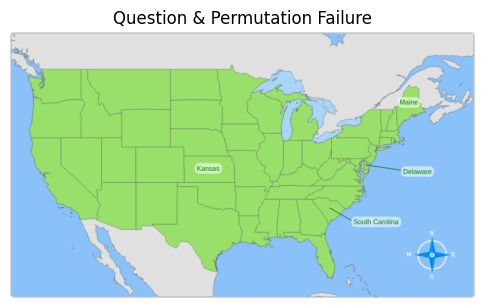

Question: Which of these states is farthest north?
Original Choices:
  A) Maine
  B) South Carolina
  C) Kansas
  D) Delaware
Original GT: A => Maine

Permutation that failed: (1, 2, 3, 0) --> New GT is D
Permuted Choices:
  A) South Carolina
  B) Kansas
  C) Delaware
  D) Maine
Model's Wrong Prediction: A
--------------------------------------------------


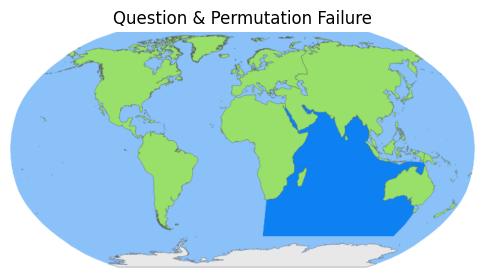

Question: Which ocean is highlighted?
Original Choices:
  A) the Indian Ocean
  B) the Atlantic Ocean
  C) the Pacific Ocean
  D) the Southern Ocean
Original GT: A => the Indian Ocean

Permutation that failed: (1, 3, 0, 2) --> New GT is C
Permuted Choices:
  A) the Atlantic Ocean
  B) the Southern Ocean
  C) the Indian Ocean
  D) the Pacific Ocean
Model's Wrong Prediction: A
--------------------------------------------------


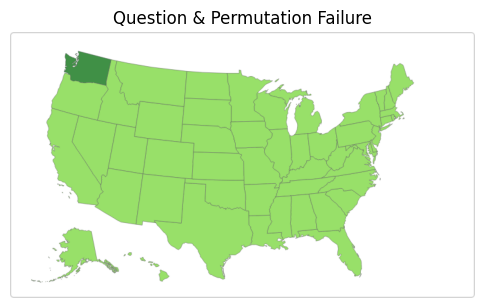

Question: What is the capital of Washington?
Original Choices:
  A) Olympia
  B) Burlington
  C) Seattle
  D) Spokane
Original GT: A => Olympia

Permutation that failed: (1, 0, 3, 2) --> New GT is B
Permuted Choices:
  A) Burlington
  B) Olympia
  C) Spokane
  D) Seattle
Model's Wrong Prediction: D
--------------------------------------------------


In [ ]:
found = find_examples_correct_original_wrong_permutation(filtered_dataset, max_examples=3)
display_wrong_permutation_examples(found)

## Position Bias

LLMs have position bias, so do VLMs. They sometimes tend to select certain option regardless of the question. \
Would this be the reason for the vulnerability?

<details open>
  <summary>How to inspect such bias?</summary>
  We move the GT answer to each of the position A/B/C/D, and calculate the accuracy for each version.
</details>

In [ ]:
def move_gt_to_position(original_choices, original_label, target_letter):
    """
    Rearrange original_choices so that the ground truth answer, indicated by original_label,
    is moved to the position corresponding to target_letter (e.g. "A", "B", "C", or "D").

    The relative order of the remaining choices is preserved.
    Returns the new choices ordering and the new label (which is target_letter).
    """
    gt_index = ord(original_label) - ord("A")
    target_index = ord(target_letter) - ord("A")
    gt_choice = original_choices[gt_index]
    # Get remaining choices preserving order
    other_choices = [choice for i, choice in enumerate(original_choices) if i != gt_index]
    # Insert the GT answer at the target position
    new_choices = other_choices[:target_index] + [gt_choice] + other_choices[target_index:]
    new_label = target_letter
    return new_choices, new_label


In [ ]:
def evaluate_position_bias(dataset):
    """
    For each example in the dataset, move the ground truth answer to each target position (A, B, C, D),
    run inference, and compute accuracy for each position.

    The dataset is expected to have:
      - "question": the question text
      - "choices": a list of four answer options
      - "answer": the index (0,1,2,3) of the correct answer
      - "image": a URL or path to the associated image
    Returns a dictionary with positions as keys and accuracy as values.
    """
    positions = ["A", "B", "C", "D"]
    results = {}

    for pos in positions:
        correct_count = 0
        total_count = 0

        for example in tqdm(dataset, desc=f"Evaluating for position {pos}"):
            question = example["question"]
            original_choices = example["choices"]
            # Convert numeric answer to a letter (e.g., 0 -> "A")
            original_label = chr(ord("A") + int(example["answer"]))
            image_url = example["image"]

            # Rearrange choices so that GT answer is at target pos (pos)
            new_choices, new_label = move_gt_to_position(original_choices, original_label, pos)
            pred = run_llava_inference(question, new_choices, image_url)

            if pred == new_label:
                correct_count += 1
            total_count += 1

        acc = correct_count / total_count if total_count else 0
        results[pos] = acc
        print(f"Position {pos}: Accuracy: {acc:.2%}")

    return results

In [ ]:
position_bias_results = evaluate_position_bias(filtered_dataset)
print("Position Bias Results:", position_bias_results)

Evaluating for position A: 100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


Position A: Accuracy: 100.00%


Evaluating for position B: 100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


Position B: Accuracy: 50.00%


Evaluating for position C: 100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Position C: Accuracy: 52.00%


Evaluating for position D: 100%|██████████| 50/50 [00:12<00:00,  4.10it/s]

Position D: Accuracy: 48.00%
Position Bias Results: {'A': 1.0, 'B': 0.5, 'C': 0.52, 'D': 0.48}


<details open>
  <summary>What does the result indicate?</summary>
  Even for the same questions, accuracy varies significantly depending on the position of the ground truth answers, indicating that VLMs do exhibit positional bias. However, since the accuracy is still higher than that of the permuted baseline, there must be additional factors at play.
</details>

## Symbol Attack

Will the symbol of options (e.g. capital letter, Roman Numeral) make a difference to the final choice of VLMs?

In [ ]:
def build_conversation_with_symbols(question, choices, symbols):
    """
    Build a conversation prompt using the provided symbol set.

    Args:
      question (str): The question text.
      choices (list): List of answer options.
      symbols (list): List of 4 symbols (e.g. ["A", "B", "C", "D"] or ["a", "b", "c", "d"] or ["I", "II", "III", "IV"]).

    Returns:
      conversation (list): A LLaVA-style conversation.
    """
    options_text = "\n".join(f"{sym}. {choice}" for sym, choice in zip(symbols, choices))
    user_text = (
        "You are a helpful assistant. "
        "Please answer the following multiple-choice question with exactly one symbol from the options provided.\n\n"
        f"Question: {question}\n"
        f"{options_text}\n"
        "Answer:"
    )
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": user_text},
                {"type": "image"},  # Placeholder for the image.
            ],
        },
    ]
    return conversation

In [ ]:
def run_llava_inference_with_symbols(question, choices, image_url_or_path, symbols):
    """
    Run inference using a prompt built with the provided symbols.
    Returns the first symbol from the model's output that matches one of the provided symbols.
    """
    conversation = build_conversation_with_symbols(question, choices, symbols)
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

    try:
        raw_image = Image.open(requests.get(image_url_or_path, stream=True).raw)
    except Exception as e:
        raw_image = Image.new("RGB", (224, 224), color="white")

    inputs = processor(
        images=raw_image,
        text=prompt,
        return_tensors="pt"
    ).to(model.device, torch.float16)

    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=16, do_sample=False)
    input_len = inputs["input_ids"].shape[1]
    output = output[:, input_len:]  # Remove the input part
    # Decode the model's output
    decoded = processor.decode(output[0], skip_special_tokens=True)
    # Look for the first occurrence of any symbol in our set:
    # for token in decoded.split():
    #     if token in symbols:
    #         return token
    # Fallback if nothing found
    return decoded

For each question in the dataset, run inference with three symbol sets:
  - Uppercase letters: ["A", "B", "C", "D"]
  - Lowercase letters: ["a", "b", "c", "d"]
  - Roman numerals:   ["I", "II", "III", "IV"]
  
If any one of these predictions is incorrect (i.e. does not match the expected symbol for the ground truth answer), \
mark the question as wrong. Otherwise, count it as correct.

In [ ]:
def evaluate_symbol_attack(dataset):
    """
    The dataset is expected to have:
      - "question": the question text
      - "choices": a list of 4 answer options
      - "answer": the index (0,1,2,3) of the correct answer
      - "image": a URL or path to the image

    Returns overall accuracy for the symbol attack.
    """
    symbol_sets = {
        "uppercase": ["A", "B", "C", "D"],
        "lowercase": ["a", "b", "c", "d"],
        "roman":     ["I", "II", "III", "IV"]
    }

    total = 0
    correct = 0

    for example in tqdm(dataset, desc="Symbol attack evaluation"):
        question = example["question"]
        choices = example["choices"]
        # Convert numeric answer to index and then expected symbol per symbol set.
        gt_index = int(example["answer"])

        image_url = example["image"]
        all_correct = True
        # For each symbol set, determine the expected symbol and run inference.
        for name, symbols in symbol_sets.items():
            expected_symbol = symbols[gt_index]
            pred_symbol = run_llava_inference_with_symbols(question, choices, image_url, symbols)
            #print(f"Predicted: {pred_symbol}, Expected: {expected_symbol} (Set: {name})")
            if pred_symbol.lower() != expected_symbol.lower():
                all_correct = False
                break  # One wrong prediction is enough
        if all_correct:
            correct += 1
        total += 1

    accuracy = correct / total if total else 0
    print(f"Symbol Attack Accuracy: {accuracy:.2%}")
    return accuracy

In [ ]:
symbol_attack_accuracy = evaluate_symbol_attack(filtered_dataset)

Symbol attack evaluation: 100%|██████████| 50/50 [00:25<00:00,  1.92it/s]

Symbol Attack Accuracy: 52.00%


## How can we fix this problem?

Let's try the most straightforward approach: **majority vote**, to find the most selected option among the permutations.

Steps:
1. Generate All Permutations
2. Inference for Each Permutation
3. Track Predictions
4. Majority Voting

In [ ]:
def run_majority_vote(question, original_choices, original_label, image_url):
    """
    Perform inference across all permutations of the 4 choices.
    Then do a majority vote in the *original labeling* (A=0, B=1, etc.).

    Returns: The final predicted letter (A/B/C/D) after majority voting.
    """
    all_permutations = list(itertools.permutations(range(4)))
    predicted_original_indices = []

    for p in all_permutations:
        # Reorder the choices under permutation p
        new_choices, _ = permute_choices_and_label(original_choices, original_label, p)

        # Run inference => predicted letter in permuted space
        pred_letter = run_llava_inference(question, new_choices, image_url)
        pred_index_in_perm = ord(pred_letter) - ord("A")  # 0..3

        # Map that index back to the original indexing
        # e.g., if pred_letter="B" => pred_index_in_perm=1 => original index = p[1]
        predicted_original_index = p[pred_index_in_perm]
        predicted_original_indices.append(predicted_original_index)

    # Majority vote in original index space
    # predicted_original_indices is a list of 24 integers in [0..3]
    # We'll pick the most frequent
    counts = [0, 0, 0, 0]  # counters for how often 0,1,2,3 appear
    for idx in predicted_original_indices:
        counts[idx] += 1

    # The majority index
    majority_index = np.argmax(counts)  # if there's a tie, np.argmax picks the first
    majority_letter = chr(ord("A") + majority_index)

    return majority_letter

In [ ]:
def evaluate_with_majority_vote(dataset):
    """
    For each example, compute the majority-vote prediction.
    Compare to the *original* label (A=0, B=1, C=2, D=3).
    Print overall accuracy.
    """
    correct_count = 0
    total_count = 0

    for example in tqdm(dataset, desc="Majority-vote evaluation"):
        question = example["question"]
        original_choices = example["choices"]  # e.g. ["Red", "Blue", "Green", "Yellow"]
        # map the numeric answer to letter, e.g. 0 => "A"
        original_label_idx = int(example["answer"])
        original_label = chr(ord("A") + original_label_idx)
        image_url = example["image"]

        # Run majority vote
        predicted_letter = run_majority_vote(question, original_choices, original_label, image_url)

        # Check correctness
        if predicted_letter == original_label:
            correct_count += 1
        total_count += 1

    accuracy = correct_count / total_count if total_count else 0
    print(f"Majority Vote Accuracy: {accuracy:.2%}")
    return accuracy


In [ ]:
evaluate_with_majority_vote(filtered_dataset)

Majority-vote evaluation: 100%|██████████| 50/50 [04:45<00:00,  5.71s/it]

Majority Vote Accuracy: 66.00%


0.66

<details open>
  <summary>Okay, it matches the original performance, but is it a good solution?</summary>
  No! It takes 4! times more compute, which is far from ideal.
</details>

In [ ]:
def is_correct_in_original_order(question, original_choices, original_label, image_url):
    """
    Run a single inference on the *unpermuted* choices.
    Return True if the prediction matches original_label.
    """
    pred_letter = run_llava_inference(question, original_choices, image_url)
    return (pred_letter == original_label)

def find_examples_correct_original_wrong_majority(dataset, num_examples=5):
    """
    Return up to `num_examples` that are correct on the original order
    but fail under majority vote across permutations.
    """
    found = []

    for example in dataset:
        question = example["question"]
        original_choices = example["choices"]
        original_label_idx = int(example["answer"])
        original_label = chr(ord("A") + original_label_idx)
        image_url = example["image"]

        # Check correctness in original order
        correct_original = is_correct_in_original_order(
            question, original_choices, original_label, image_url
        )

        # Check correctness under majority vote
        predicted_letter_mv = run_majority_vote(
            question, original_choices, original_label, image_url
        )
        correct_mv = (predicted_letter_mv == original_label)

        if correct_original and not correct_mv:
            found.append(example)
            if len(found) >= num_examples:
                break

    return found


## Summary and Conclusion

In this hands-on tutorial, we've explored the robustness of VLMs to permutation in multiple-choice questions. Specifically,

1. **Model Setup**: We showed how to load LLaVA-1.5-7B with HF and run inference.

2. **Dataset Exploration**: We worked with the ScienceQA dataset, which contains diverse multiple-choice questions with images.

3. **Basic MCQ Inference**: We implemented a pipeline to process images and text, run inference, and extract answers in the format of A/B/C/D.

4. **Permutation Testing**: We tested how changing the order of answer choices affects model predictions, revealing a key vulnerability in VLMs.

5. **Results Analysis**: We discovered that VLMs often fail to maintain consistent answers when the order of choices is permuted, despite the semantic meaning remaining the same. This suggests models might be exploiting positional biases rather than truly understanding the question-answer relationship.

### Key Insights:
- VLMs tend to perform well on MCQs in their original format
- However, their performance drops significantly when answer choices are reordered
- This reveals a crucial limitation in current VLM reasoning capabilities
- For robust evaluation, we should consider permutation invariance as a critical test

### Future Directions:
- Developing training methods that encourage permutation invariance
- Creating evaluation benchmarks that account for this vulnerability
